In [1]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import napari
import colorcet as cc
import pandas as pd

import dnt

spots_directory = Path(r"D:\Tracking\DrosophilaNucleusTracking\data\spots")
save_path = Path(r"D:\Tracking\DrosophilaNucleusTracking\figures\output\surface_integrals")

include = [1, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14]
condition = [0, 0, 0, 0, 0, 1, 1, 2, 2, 2, 2]
earliest_frames = [25, 43, 63, 80, 55, 150, 23, 36, 17, 50, 3]
# include = [9]
# earliest_frames = [55]

dnt.set_plot_style()

spots_dfs, metadatas, stems = dnt.load_spots_data(spots_directory, include)

df = spots_dfs[0]
cycles = [10, 11, 12, 13, 14]

print(df.columns)

['lightsheet_20241104_spots', 'lightsheet_20250131_spots', 'lightsheet_20250206_spots', 'lightsheet_20250414_spots', 'lightsheet_20250625_spots', 'lightsheet_20250627_spots', 'lightsheet_20250702_spots', 'lightsheet_20250704_spots', 'lightsheet_20250705_spots', 'lightsheet_bcd_20251105a_spots', 'lightsheet_bcd_20251106_spots', 'lightsheet_trk_20250318_spots', 'lightsheet_trk_20250319a_spots', 'lightsheet_trk_20250319b_spots', 'lightsheet_trk_20250321_spots', 'lightsheet_trk_20250325_spots']


reading spots dfs: 0it [00:00, ?it/s]

[  0  35  60 110 160 280] 25 246


reading spots dfs: 2it [00:01,  1.53it/s]

[  0  55  90 140 200 350] 0 332


reading spots dfs: 5it [00:03,  1.40it/s]

[  0  65 100 150 225 350] 0 311


reading spots dfs: 7it [00:05,  1.25it/s]

[  0  85 125 170 225 350] 0 325


reading spots dfs: 8it [00:06,  1.03it/s]

[  0  42  65 130 200 350] 0 320


reading spots dfs: 9it [00:09,  1.24s/it]

[  0 150 180 240 300 400] 0 397


reading spots dfs: 10it [00:10,  1.21s/it]

[  0  60 100 150 220 340] 0 324


reading spots dfs: 11it [00:11,  1.24s/it]

[  0  25  60 120 200 280] 0 280


reading spots dfs: 12it [00:12,  1.28s/it]

[  0  50  80 120 200 280] 0 280


reading spots dfs: 13it [00:14,  1.25s/it]

[  0  25  55 100 180 280] 0 241


reading spots dfs: 14it [00:15,  1.22s/it]

[  0  55  90 140 200 350] 0 311


reading spots dfs: 16it [00:16,  1.06s/it]

Index(['time_since_nc11', 'z', 'y', 'x', 'AP', 'theta', 'area', 'radius',
       'intensity_mean', 'cycle', 'display_z', 'display_y', 'display_x',
       'px_z', 'px_y', 'px_x', 'px_area', 'uv_v', 'uv_u', 'uv_z',
       'uv_distance_from_edge', 'distance_from_surface', 'uv_area',
       'area_distortion', 'mesh_name', 'interpolated', 'track_id',
       'tracklet_id', 'parent_id', 'n_children', 'n_parents', 'AP_raw',
       'AP_um', 'AP_um_centered', 'um_from_anterior', 'um_from_posterior',
       'distance_to_pole', 'time', 'trk', 'problematic', 'frame',
       'trackmate_id', 'status', 'source', 'is_parent', 'is_child',
       'pseudotime', 'distance', 'cycle_pseudotime', 'dx', 'dy', 'dz', 'dAP',
       'dtheta', 'dtot', 'dAP_abs'],
      dtype='object')


In [19]:
df["is_child"].value_counts()

is_child
False    759027
True      13058
Name: count, dtype: int64

In [12]:
print(stems)

['lightsheet_20250131_spots', 'lightsheet_20250625_spots', 'lightsheet_20250702_spots', 'lightsheet_20250704_spots', 'lightsheet_20250705_spots', 'lightsheet_bcd_20251105a_spots', 'lightsheet_bcd_20251106_spots', 'lightsheet_trk_20250318_spots', 'lightsheet_trk_20250319a_spots', 'lightsheet_trk_20250319b_spots', 'lightsheet_trk_20250321_spots']


In [2]:
import napari
viewer = napari.Viewer(ndisplay=3)
pal = dnt.palettes.nc
df = spots_dfs[4]
points = df[["frame", "z", "y", "x"]].values
colors = [pal[int(cycle)] for cycle in df["cycle"]]
viewer.add_points(points, size=5, face_color=colors, name="nuclei")
napari.run()


In [4]:
import dnt
import pandas as pd
from collections import defaultdict

all_densities = defaultdict(list)

bin_sizes = []

counts = []
sas = []
lengths = []

for k in range(len(spots_dfs)):
    df = spots_dfs[k]
    df = df[df["frame"] >= earliest_frames[k]].copy()

    min_mvmt_frames, times = dnt.find_stationary_timepoints(df)

    points = df[df["frame"] == min_mvmt_frames[-1]][["x", "y", "z"]].values
    aps = df[df["frame"] == min_mvmt_frames[-1]]["AP"].values
    mesh = dnt.mesh_from_points(points)

    ap_vals = np.linspace(0.05, 0.95, 6)
    y_max = points[:, 1].max()
    y_min = points[:, 1].min()
    y_vals = y_min + ap_vals * (y_max - y_min)

    bins = [-1] + list(ap_vals) + [2]

    df["AP_bin"] = pd.cut(df["AP"], bins=bins, labels=np.arange(len(bins)-1))
    df["AP_bin"] = df["AP_bin"].astype(int)

    try:
        surface_areas = dnt.calculate_surface_area_along_axis(mesh, y_vals)
    except Exception as e:
        mesh = dnt.smoothed_mesh_from_points(points)
        surface_areas = dnt.calculate_surface_area_along_axis(mesh, y_vals)
        # print(f"Error calculating surface areas for embryo {k}: {e}")
        # continue

    # flip order of surface areas if y_max corresponds to AP=0
    if aps[np.argmax(points[:, 1])] < aps[np.argmin(points[:, 1])]:
        surface_areas = surface_areas[::-1]

    total_surface_area = surface_areas.sum()
    nc_14_nuclei = len(df[df["frame"] == min_mvmt_frames[-1]])
    print(stems[k])
    print(nc_14_nuclei, total_surface_area, nc_14_nuclei / total_surface_area)
    print(surface_areas)

    counts.append(nc_14_nuclei)
    sas.append(total_surface_area)
    lengths.append(y_max - y_min)

    surface_areas = surface_areas[1:-1]

    rel_densities = []

    for frame, cycle in zip(min_mvmt_frames, cycles):
        df_subset = df[df["frame"] == frame]
        df_subset = df_subset[df_subset["AP_bin"].isin([1, 2, 3, 4, 5])]

        num_nuclei = df_subset.groupby("AP_bin").size()
        print(num_nuclei.values)

        actual_density = df_subset.groupby("AP_bin").size() / surface_areas
        rel_density = actual_density / (len(df_subset) / total_surface_area)

        rel_densities.append(rel_density.values)

        for bin_idx, (actual, rel) in enumerate(zip(actual_density.values, rel_density.values)):
            all_densities["cycle"].append(cycle)
            all_densities["embryo"].append(k)
            all_densities["AP_bin"].append(bin_idx + 1)
            all_densities["actual_density"].append(actual)
            all_densities["rel_density"].append(rel)
            all_densities["surface_area"].append(surface_areas[bin_idx])
            all_densities["condition"].append(condition[k])

    spots_dfs[k] = df
    bin_sizes.append(surface_areas)


lightsheet_20250131_spots
4862 242535.078125 0.020046584756264318
[ 6262.30761719 37117.81738281 47835.34375    50729.609375
 49315.0625     41716.59375     9558.34375   ]
[50 76 86 78 46]
[108 144 157 145  95]
[186 271 292 281 209]
[352 509 559 556 419]
[ 667  973 1065 1026  854]
lightsheet_20250625_spots
5605 230502.421875 0.024316447325831377
[ 6585.22314453 34893.74951172 43281.16796875 46430.96875
 46731.703125   41628.125      10951.484375  ]
[43 68 94 89 64]
[101 136 163 170 129]
[180 261 315 334 275]
[364 509 612 636 547]
[ 724 1051 1218 1198 1002]
lightsheet_20250702_spots
5457 240034.34375 0.022734246752971157
[ 6754.75       37237.203125   46710.03125    49759.5703125
 49068.62890625 41797.91210938  8706.24804688]
[52 76 91 81 55]
[101 154 164 163 113]
[189 297 334 321 229]
[378 562 650 616 479]
[ 718 1048 1256 1170  901]
lightsheet_20250704_spots
5847 241506.1875 0.02421055982261324
[ 6631.01953125 38203.58203125 46754.6328125  49354.296875
 48895.421875   41986.90625     9

In [20]:
import napari
viewer = napari.Viewer(ndisplay=3)
pal = dnt.palettes.ap
df = spots_dfs[3]
points = df[["frame", "z", "y", "x"]].values
colors = [pal[int(b) % 5] for b in df["AP_bin"]]
viewer.add_points(points, size=5, face_color=colors, name="nuclei")
napari.run()

C:\Users\Harrison\AppData\Local\Temp\ipykernel_28560\1372625324.py:14: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.barplot(data=subset_df, x="AP_bin", y="rel_density", hue="condition", palette=condition_pal, lw=0.5, edgecolor='k')


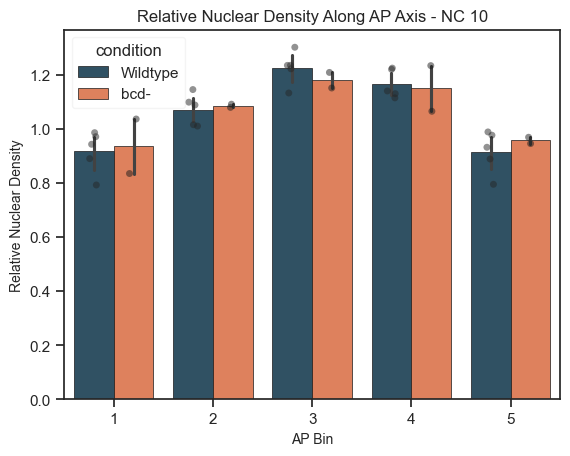

C:\Users\Harrison\AppData\Local\Temp\ipykernel_28560\1372625324.py:14: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.barplot(data=subset_df, x="AP_bin", y="rel_density", hue="condition", palette=condition_pal, lw=0.5, edgecolor='k')


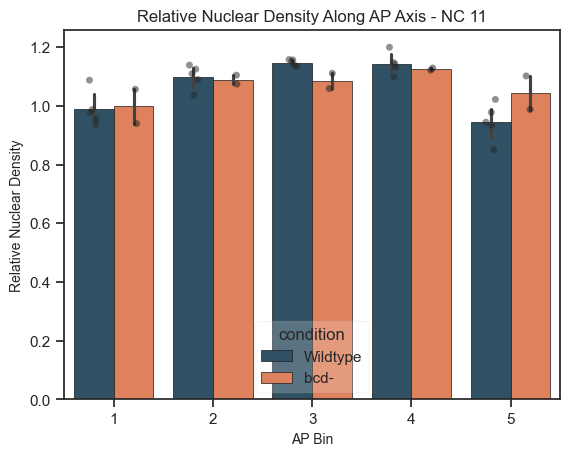

C:\Users\Harrison\AppData\Local\Temp\ipykernel_28560\1372625324.py:14: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.barplot(data=subset_df, x="AP_bin", y="rel_density", hue="condition", palette=condition_pal, lw=0.5, edgecolor='k')


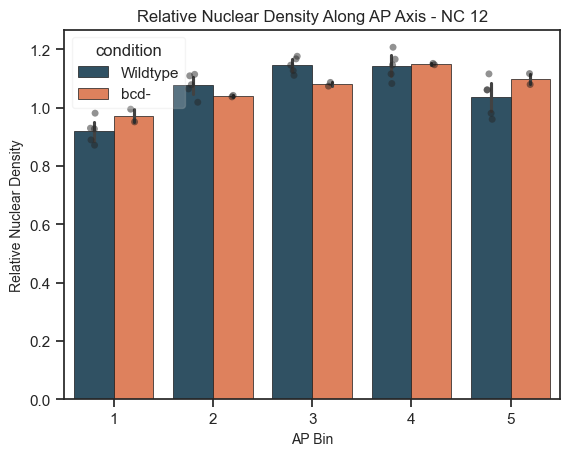

C:\Users\Harrison\AppData\Local\Temp\ipykernel_28560\1372625324.py:14: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.barplot(data=subset_df, x="AP_bin", y="rel_density", hue="condition", palette=condition_pal, lw=0.5, edgecolor='k')


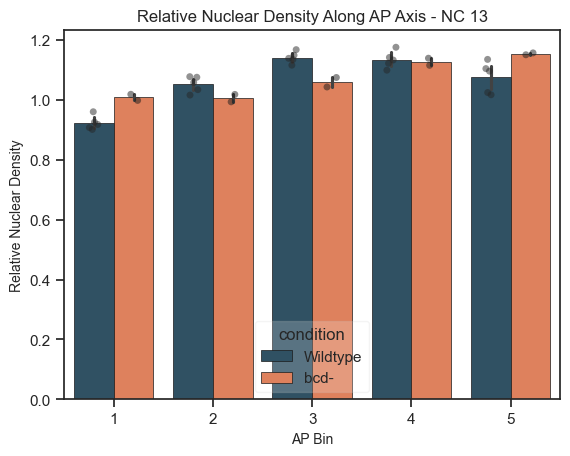

C:\Users\Harrison\AppData\Local\Temp\ipykernel_28560\1372625324.py:14: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.barplot(data=subset_df, x="AP_bin", y="rel_density", hue="condition", palette=condition_pal, lw=0.5, edgecolor='k')


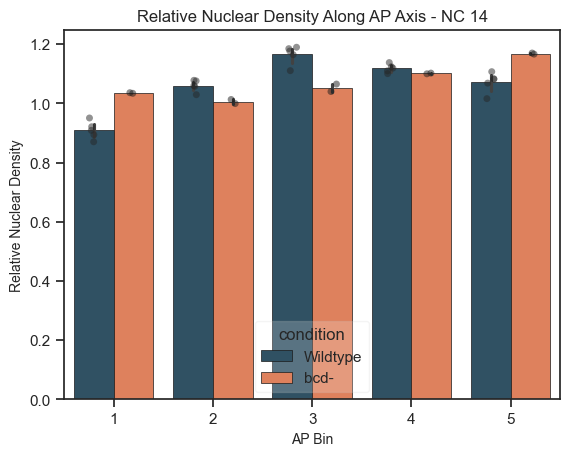

In [8]:
density_df = pd.DataFrame(all_densities)

condition_pal = ["#28536B", "#F37748", "#EEE1B3"]

for cycle in cycles:
    subset_df = density_df[density_df["cycle"] == cycle]
    subset_df = subset_df[subset_df["condition"].isin([0, 1])].copy()
    # subset_df = subset_df[subset_df["embryo"] != 6].copy()
    subset_df = subset_df[subset_df["AP_bin"].isin([1, 2, 3, 4, 5])].copy()

    subset_df["count"] = subset_df["actual_density"] * subset_df["surface_area"]
    subset_df["condition"] = subset_df["condition"].replace({0: "Wildtype", 1: "bcd-"})

    sns.barplot(data=subset_df, x="AP_bin", y="rel_density", hue="condition", palette=condition_pal, lw=0.5, edgecolor='k')
    sns.stripplot(data=subset_df, x="AP_bin", y="rel_density", hue="condition", dodge=True, palette='dark:k', alpha=0.5, legend=False)

    plt.xlabel("AP Bin")
    plt.ylabel("Relative Nuclear Density")
    plt.title(f"Relative Nuclear Density Along AP Axis - NC {cycle}")

    plt.savefig(save_path / f"nc{cycle}_relative_density_ap_condition.png", dpi=300, bbox_inches='tight')
    plt.show()


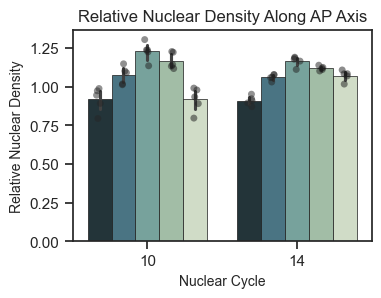

In [11]:
plt.subplots(figsize=(4, 3))
plt.tight_layout(pad=2.0)
density_df = pd.DataFrame(all_densities)
density_df = density_df[density_df["condition"] == 0]
density_df = density_df[density_df["cycle"].isin([10, 14])]
density_df = density_df[density_df["AP_bin"].isin([1, 2, 3, 4, 5])].copy()
density_df["AP_bin"] = density_df["AP_bin"].replace({1: "Anterior", 2: "Mid-Anterior", 3: "Middle", 4:"Mid-Posterio", 5: "Posterior"})

ap_pal = list(np.array(dnt.palettes.ap)[[0, 1, 2, 3, 4]])
sns.barplot(data=density_df, x="cycle", y="rel_density", hue="AP_bin", palette=ap_pal, lw=0.5, edgecolor='k')
sns.stripplot(data=density_df, x="cycle", y="rel_density", hue="AP_bin", dodge=True, palette='dark:k', alpha=0.5, legend=False)

plt.xlabel("Nuclear Cycle")
plt.ylabel("Relative Nuclear Density")
plt.title("Relative Nuclear Density Along AP Axis")
plt.gca().get_legend().remove()
plt.savefig(save_path / "nc_relative_density_ap_wt.png", dpi=300, bbox_inches='tight')
plt.show()


In [12]:
timepoints_dfs = []

for i, df in enumerate(spots_dfs):
    earliest_frame = earliest_frames[i]
    df = df[df["frame"] >= earliest_frame]
    spots_dfs[i] = df

    min_mvmt_frames, times = dnt.find_stationary_timepoints(df)

    timepoints_dfs.append(dnt.generate_timepoint_df(df))

In [14]:
displacement_save_path = save_path.parent / "displacements"
displacement_save_path.mkdir(parents=True, exist_ok=True)

cycle_dfs = defaultdict(list)

for i, df in enumerate(spots_dfs):

    min_mvmt_frames, times = dnt.find_stationary_timepoints(df)

    df = df.copy()
    df["id"] = df.index
    df["first_id"] = df["track_id"].map(df.groupby("track_id")["id"].first())
    df["first_cycle"] = df["track_id"].map(df.groupby("track_id")["cycle"].first())
    df = df[df["first_cycle"] == 10].copy()

    displacements = {}
    for col in ["z", "y", "x", "AP"]:
        displacements[col] = df[col] - df["first_id"].map(df[col])

    df["dAP"] = displacements["AP"]
    df["prev_cycle"] = df["cycle"] - 1

    for j, frame in enumerate(min_mvmt_frames[1:]):
        cycle_df = df[df["frame"] == frame]
        t = cycle_df.groupby("track_id")[["AP", "dAP", "source"]].mean()

        sns.scatterplot(t, x="AP", y="dAP", color=dnt.palettes.nc[j+11], edgecolor="k")

        plt.ylabel("AP movement")
        plt.xlabel("AP position at cycle 10")

        plt.axhline(0, color="k", linestyle="--", linewidth=5)
        plt.title("Nuclear movement along AP axis")
        plt.savefig(displacement_save_path / f"{stems[i]}_nc{j+11}_movement_ap.png", dpi=300, bbox_inches='tight')

        plt.close()

        cycle_dfs[j+11].append(t)

In [ ]:
plt.subplots(figsize=(4, 3))
plt.tight_layout(pad=2.0)
density_df = pd.DataFrame(all_densities)
density_df["bcd"] = density_df["embryo"] == density_df["embryo"].max()
density_df = density_df[density_df["cycle"].isin([10, 14])]
density_df = density_df[density_df["AP_bin"].isin([1, 2, 3, 4, 5])].copy()
density_df["AP_bin"] = density_df["AP_bin"].replace({1: "Anterior", 2: "Mid-Anterior", 3: "Middle", 4:"Mid-Posterio", 5: "Posterior"})

ap_pal = list(np.array(dnt.palettes.ap)[[0, 1, 2, 3, 4]])
sns.barplot(data=density_df, x="cycle", y="rel_density", hue="AP_bin", palette=ap_pal, lw=0.5, edgecolor='k')
sns.stripplot(data=density_df, x="cycle", y="rel_density", hue="AP_bin", dodge=True, palette='dark:k', alpha=0.5, legend=False)

plt.xlabel("Nuclear Cycle")
plt.ylabel("Relative Nuclear Density")
plt.title("Relative Nuclear Density Along AP Axis")
plt.gca().get_legend().remove()
plt.show()

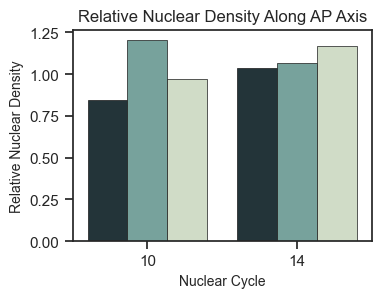

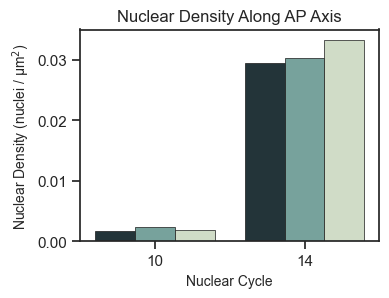

In [22]:
plt.subplots(figsize=(4, 3))
plt.tight_layout(pad=2.0)
density_df = pd.DataFrame(all_densities)
density_df = density_df[density_df["cycle"].isin([10, 14])]
density_df = density_df[density_df["AP_bin"].isin([1, 3, 5])].copy()
density_df["AP_bin"] = density_df["AP_bin"].replace({1: "Anterior", 3: "Middle", 5: "Posterior"})
ap_pal = list(np.array(dnt.palettes.ap)[[0, 2, 4]])
sns.barplot(data=density_df, x="cycle", y="rel_density", hue="AP_bin", palette=ap_pal, lw=0.5, edgecolor='k')
# sns.stripplot(data=density_df, x="cycle", y="rel_density", hue="AP_bin", dodge=True, palette='dark:k', alpha=0.5, legend=False)
plt.xlabel("Nuclear Cycle")
plt.ylabel("Relative Nuclear Density")
plt.title("Relative Nuclear Density Along AP Axis")
plt.gca().get_legend().remove()
plt.savefig(save_path / "nc_relative_density_ap.png", dpi=300, bbox_inches='tight')
plt.show()

plt.subplots(figsize=(4, 3))
plt.tight_layout(pad=2.0)
sns.barplot(data=density_df, x="cycle", y="actual_density", hue="AP_bin", palette=ap_pal, lw=0.5, edgecolor='k', legend=False)
# sns.stripplot(data=density_df, x="cycle", y="actual_density", hue="AP_bin", dodge=True, palette='dark:k', alpha=0.5, legend=False)
plt.xlabel("Nuclear Cycle")
plt.ylabel("Nuclear Density (nuclei / μm$^2$)")
plt.title("Nuclear Density Along AP Axis")
# plt.legend(title="AP bin")
plt.savefig(save_path / "nc_raw_density_ap.png", dpi=300, bbox_inches='tight')
plt.show()

# density_df = pd.DataFrame(all_densities)
# sns.barplot(data=density_df, x="AP_bin", y="surface_area", hue="AP_bin", palette=dnt.palettes.ap)
#
# plt.show()

## Nuclear fallout

0
4910
[5 6 1 3 4 7 2]


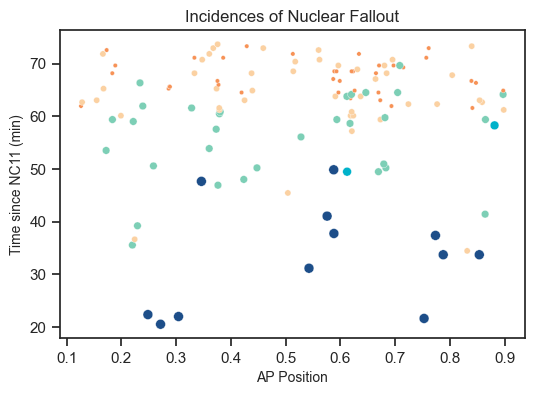

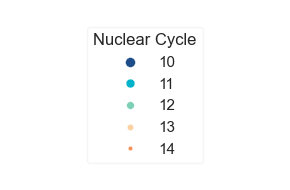

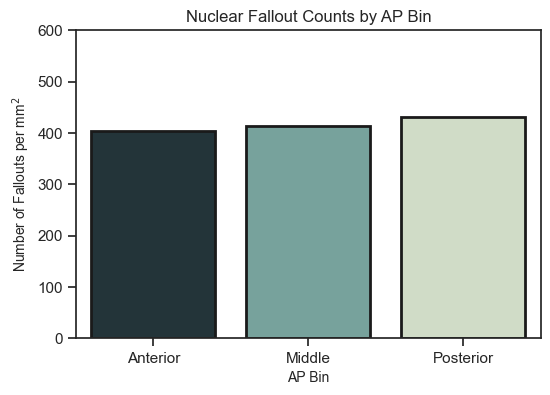

In [5]:
df = spots_dfs[0]
print((df["frame"] == 5).sum())
print((df["frame"] == 215).sum())
print(df["status"].unique())

terms = df[df["status"] == 2].copy()
terms = terms[terms["AP_bin"].isin([1, 2, 3, 4, 5])].copy()
fig, ax = plt.subplots(figsize=(6, 4))
sns.scatterplot(terms, x="AP", y="time_since_nc11", hue="cycle", size="cycle", sizes=[50, 40, 30, 20, 10], palette=dnt.palettes.nc)
plt.xlabel("AP Position")
plt.ylabel("Time since NC11 (min)")
plt.title("Incidences of Nuclear Fallout")
plt.legend(title="Nuclear Cycle", loc="lower right")

# save legend separately
handles, labels = ax.get_legend_handles_labels()
fig_legend = plt.figure(figsize=(3, 2))
ax_legend = fig_legend.add_subplot(111)
ax_legend.legend(handles, labels, loc='center', title="Nuclear Cycle")
ax_legend.axis('off')
fig_legend.tight_layout()
fig_legend.savefig(save_path / "fallout_legend.png", dpi=300)

# turn off legend on main plot
ax.legend_.remove()
fig.savefig(save_path / "nc_fallout_ap_time.png", dpi=300, bbox_inches='tight')
plt.show()

fig, ax = plt.subplots(figsize=(6, 4))
terms = terms[terms["AP_bin"].isin([1, 3, 5])].copy()
terms["AP_bin"] = terms["AP_bin"].replace({1: "Anterior", 3: "Middle", 5: "Posterior"})

bin_counts = terms.groupby("AP_bin")["frame"].count()
sns.barplot(x=bin_counts.index, y=10**6*np.array(bin_counts.values)/ np.array(bin_sizes[0])[[0, 2, 4]], hue=bin_counts.index, palette=ap_pal, lw=2, edgecolor='k')
plt.xlabel("AP Bin")
plt.ylabel("Number of Fallouts per mm$^2$")
plt.ylim(0, 600)
plt.title("Nuclear Fallout Counts by AP Bin")
plt.savefig(save_path / "nc_fallout_ap_bin_counts.png", dpi=300, bbox_inches='tight')
plt.show()

0
4910
[5 6 1 3 4 7 2]


C:\Users\Harrison\AppData\Local\Temp\ipykernel_35128\1578880413.py:11: UserWarning: The sizes list has more values (5) than needed (1), which may not be intended.
  sns.scatterplot(terms, x="AP", y="time_since_nc11", hue="cycle", size="cycle", sizes=[50, 40, 30, 20, 10], palette=dnt.palettes.nc)


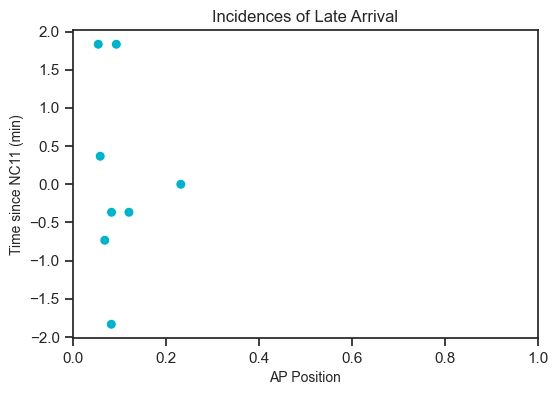

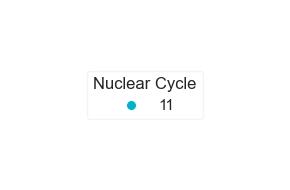

In [9]:
df = spots_dfs[0]
print((df["frame"] == 5).sum())
print((df["frame"] == 215).sum())
print(df["status"].unique())

terms = df[df["status"] == 5].copy()
terms = terms[terms["cycle"] > 10]
terms = terms[terms["time_since_nc11"] < 10]
terms = terms[terms["AP_bin"].isin([1, 2, 3, 4, 5])].copy()
fig, ax = plt.subplots(figsize=(6, 4))
sns.scatterplot(terms, x="AP", y="time_since_nc11", hue="cycle", size="cycle", sizes=[50, 40, 30, 20, 10], palette=dnt.palettes.nc)
plt.xlim(0, 1)
plt.xlabel("AP Position")
plt.ylabel("Time since NC11 (min)")
plt.title("Incidences of Late Arrival")
plt.legend(title="Nuclear Cycle", loc="lower right")

# save legend separately
handles, labels = ax.get_legend_handles_labels()
fig_legend = plt.figure(figsize=(3, 2))
ax_legend = fig_legend.add_subplot(111)
ax_legend.legend(handles, labels, loc='center', title="Nuclear Cycle")
ax_legend.axis('off')
fig_legend.tight_layout()
fig_legend.savefig(save_path / "arrival_legend.png", dpi=300)

# turn off legend on main plot
ax.legend_.remove()
fig.savefig(save_path / "nc_arrival_ap_time.png", dpi=300, bbox_inches='tight')
plt.show()

# fig, ax = plt.subplots(figsize=(6, 4))
# terms = terms[terms["AP_bin"].isin([1, 3, 5])].copy()
# terms["AP_bin"] = terms["AP_bin"].replace({1: "Anterior", 3: "Middle", 5: "Posterior"})
#
# bin_counts = terms.groupby("AP_bin")["frame"].count()
# sns.barplot(x=bin_counts.index, y=10**6*np.array(bin_counts.values)/ np.array(bin_sizes[0])[[0, 2, 4]], hue=bin_counts.index, palette=ap_pal, lw=2, edgecolor='k')
# plt.xlabel("AP Bin")
# plt.ylabel("Number of Fallouts per mm$^2$")
# plt.ylim(0, 600)
# plt.title("Nuclear Fallout Counts by AP Bin")
# plt.savefig(save_path / "nc_fallout_ap_bin_counts.png", dpi=300, bbox_inches='tight')
# plt.show()

In [20]:
import dnt
import pandas as pd
from collections import defaultdict

all_densities = defaultdict(list)

bin_sizes = []

counts = []
sas = []
lengths = []

cycles_complete = [11, 12, 13]

for k in range(6):
    df = spots_dfs[k]
    df = df[df["frame"] >= earliest_frames[k]].copy()

    min_mvmt_frames, times = dnt.find_stationary_timepoints(df)

    points = df[df["frame"] == min_mvmt_frames[-1]][["x", "y", "z"]].values
    mesh = dnt.mesh_from_points(points)

    ap_vals = np.linspace(0.05, 0.95, 6)
    y_max = points[:, 1].max()
    y_min = points[:, 1].min()
    y_vals = y_min + ap_vals * (y_max - y_min)

    bins = [-1] + list(ap_vals) + [2]

    df["AP_bin"] = pd.cut(df["AP"], bins=bins, labels=np.arange(len(bins)-1))
    df["AP_bin"] = df["AP_bin"].astype(int)

    surface_areas = dnt.calculate_surface_area_along_axis(mesh, y_vals)
    total_surface_area = surface_areas.sum()

    nc_14_nuclei = len(df[df["frame"] == min_mvmt_frames[-1]])
    print(nc_14_nuclei, total_surface_area, nc_14_nuclei / total_surface_area)

    counts.append(nc_14_nuclei)
    sas.append(total_surface_area)
    lengths.append(y_max - y_min)

    surface_areas = surface_areas[1:-1]

    rel_densities = []

    for frame, cycle in zip(min_mvmt_frames[1:-1], cycles_complete):

        df_cycle_subset = df[df["cycle"] == cycle].copy()
        df_cycle_subset["time_in_cycle"] = df_cycle_subset.groupby("track_id")["time_since_nc11"].transform(lambda x: (x * 0) + (x.max() - x.min()))

        df_subset = df_cycle_subset[df_cycle_subset["frame"] == frame]
        df_subset = df_subset[df_subset["AP_bin"].isin([1, 2, 3, 4, 5])]

        actual_density = df_subset.groupby("AP_bin").size() / surface_areas
        rel_density = actual_density / (len(df_subset) / total_surface_area)

        rel_densities.append(rel_density.values)

        for bin_idx, (actual, rel) in enumerate(zip(actual_density.values, rel_density.values)):
            all_densities["cycle"].append(cycle)
            all_densities["embryo"].append(k)
            all_densities["AP_bin"].append(bin_idx + 1)
            all_densities["actual_density"].append(actual)
            all_densities["rel_density"].append(rel)
            all_densities["surface_area"].append(surface_areas[bin_idx])
            all_densities["time_in_cycle"].append(df_subset[df_subset["AP_bin"] == bin_idx + 1]["time_in_cycle"].mean())


    spots_dfs[k] = df
    bin_sizes.append(surface_areas)

4862 242535.078125 0.020046584756264318
4772 225833.484375 0.021130613173713515
5605 230502.421875 0.024316447325831377
5457 240034.34375 0.022734246752971157
5847 241506.1875 0.02421055982261324
5179 243434.625 0.021274705683302038


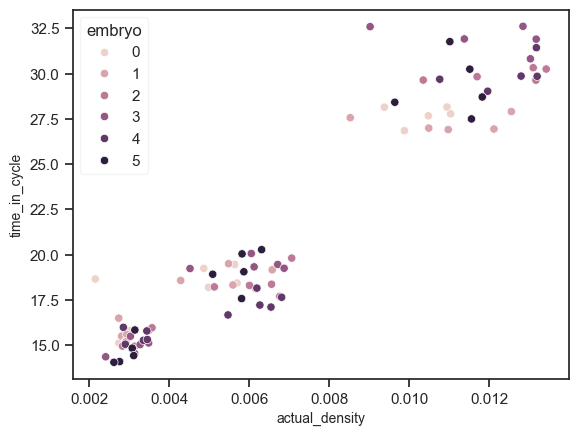

In [23]:
density_df = pd.DataFrame(all_densities)

sns.scatterplot(data=density_df, x="actual_density", y="time_in_cycle", hue="embryo")
plt.show()

# first neighbor CoV

In [13]:
import dnt
import pandas as pd
from collections import defaultdict
from scipy.spatial.distance import cdist
from tqdm import tqdm

all_distances = defaultdict(list)

for k in tqdm(range(6)):
    df = spots_dfs[k]
    df = df[df["frame"] >= earliest_frames[k]].copy()

    min_mvmt_frames, times = dnt.find_stationary_timepoints(df)

    for frame, cycle in zip(min_mvmt_frames, cycles):
        df_subset = df[df["frame"] == frame]
        points = df_subset[["x", "y", "z"]].values
        pairwise_distances = cdist(points, points)
        np.fill_diagonal(pairwise_distances, 500)

        first_neighbor_distances = pairwise_distances.min(axis=1)

        all_distances["cycle"].append(int(cycle))
        all_distances["embryo"].append(k)
        all_distances["mean_distance"].append(first_neighbor_distances.mean())
        all_distances["std_distance"].append(first_neighbor_distances.std())
        all_distances["cov_distance"].append(first_neighbor_distances.std() / first_neighbor_distances.mean())

distance_df = pd.DataFrame(all_distances)


100%|██████████| 6/6 [00:06<00:00,  1.00s/it]


In [15]:
dnt.palettes.nc

{10: '#1d4e89', 11: '#00b2ca', 12: '#7dcfb6', 13: '#fbd1a2', 14: '#f79256'}

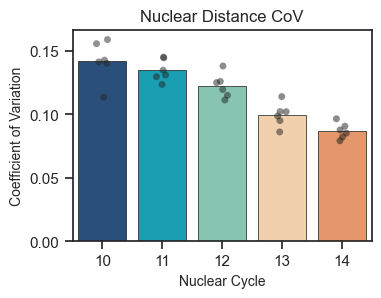

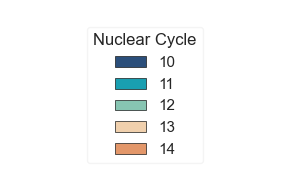

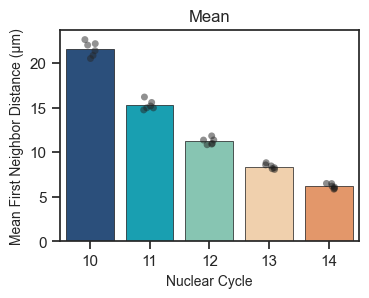

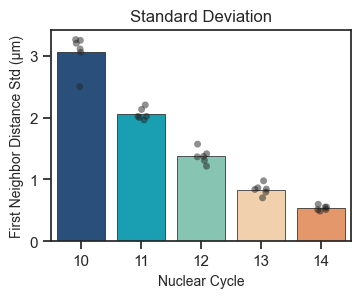

In [25]:
distance_df

fig, ax = plt.subplots(figsize=(4, 3))
plt.tight_layout(pad=2.0)
sns.barplot(data=distance_df, x="cycle", y="cov_distance", hue="cycle", palette=dnt.palettes.nc, lw=0.5, edgecolor='k', errorbar=None)
sns.stripplot(data=distance_df, x="cycle", y="cov_distance", hue="cycle", palette='dark:k', alpha=0.5, legend=False)

plt.xlabel("Nuclear Cycle")
plt.ylabel("Coefficient of Variation")
plt.title("Nuclear Distance CoV")
plt.legend(title="Nuclear Cycle", loc="lower right")

# save legend separately
handles, labels = ax.get_legend_handles_labels()
fig_legend = plt.figure(figsize=(3, 2))
ax_legend = fig_legend.add_subplot(111)
ax_legend.legend(handles, labels, loc='center', title="Nuclear Cycle")
ax_legend.axis('off')
fig_legend.tight_layout()
fig_legend.savefig(save_path / "nc_cov_legend.png", dpi=300)

# turn off legend on main plot
ax.legend_.remove()
fig.savefig(save_path / "nc_cov_time.png", dpi=300, bbox_inches='tight')
plt.show()

fig, ax = plt.subplots(figsize=(4, 3))
plt.tight_layout(pad=2.0)
sns.barplot(data=distance_df, x="cycle", y="mean_distance", hue="cycle", palette=dnt.palettes.nc, lw=0.5, edgecolor='k', errorbar=None, legend=False)
sns.stripplot(data=distance_df, x="cycle", y="mean_distance", hue="cycle", palette='dark:k', alpha=0.5, legend=False)
plt.xlabel("Nuclear Cycle")
plt.ylabel("Mean First Neighbor Distance (μm)")
plt.title("Mean")
plt.savefig(save_path / "nc_mean_distance_time.png", dpi=300, bbox_inches='tight')
plt.show()

fig, ax = plt.subplots(figsize=(4, 3))
plt.tight_layout(pad=2.0)
sns.barplot(data=distance_df, x="cycle", y="std_distance", hue="cycle", palette=dnt.palettes.nc, lw=0.5, edgecolor='k', errorbar=None, legend=False)
sns.stripplot(data=distance_df, x="cycle", y="std_distance", hue="cycle", palette='dark:k', alpha=0.5, legend=False)
plt.xlabel("Nuclear Cycle")
plt.ylabel("First Neighbor Distance Std (μm)")
plt.title("Standard Deviation")
plt.savefig(save_path / "nc_std_distance_time.png", dpi=300, bbox_inches='tight')
plt.show()

prev_bin   1.0    2.0    3.0    4.0   5.0   6.0
AP_bin                                         
0          3.0    0.0    0.0    0.0   0.0   0.0
1         85.0   11.0    0.0    0.0   0.0   0.0
2          0.0  131.0    8.0    0.0   0.0   0.0
3          0.0    0.0  150.0    3.0   0.0   0.0
4          0.0    0.0    8.0  134.0   1.0   0.0
5          0.0    0.0    0.0   11.0  84.0   1.0
6          0.0    0.0    0.0    0.0   4.0  20.0
prev_bin   0.0    1.0    2.0    3.0    4.0    5.0   6.0
AP_bin                                                 
0         16.0    3.0    0.0    0.0    0.0    0.0   0.0
1          2.0  187.0    0.0    0.0    0.0    0.0   0.0
2          0.0   30.0  246.0    0.0    0.0    0.0   0.0
3          0.0    0.0   40.0  252.0    0.0    0.0   0.0
4          0.0    0.0    0.0   59.0  230.0    0.0   0.0
5          0.0    0.0    0.0    0.0   61.0  146.0   0.0
6          0.0    0.0    0.0    0.0    0.0   29.0  17.0
prev_bin   0.0    1.0    2.0    3.0    4.0    5.0   6.0
AP_bin  

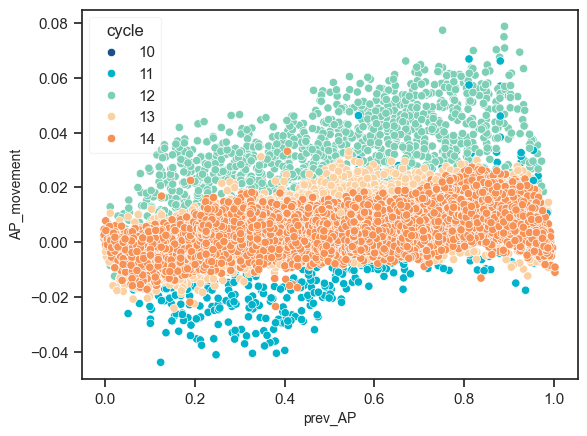

prev_bin       0.0    1.0    2.0     3.0    4.0    5.0    6.0
cycle AP_bin                                                 
11    0        0.0    3.0    0.0     0.0    0.0    0.0    0.0
      1        0.0   85.0   11.0     0.0    0.0    0.0    0.0
      2        0.0    0.0  131.0     8.0    0.0    0.0    0.0
      3        0.0    0.0    0.0   150.0    3.0    0.0    0.0
      4        0.0    0.0    0.0     8.0  134.0    1.0    0.0
      5        0.0    0.0    0.0     0.0   11.0   84.0    1.0
      6        0.0    0.0    0.0     0.0    0.0    4.0   20.0
12    0       16.0    3.0    0.0     0.0    0.0    0.0    0.0
      1        2.0  187.0    0.0     0.0    0.0    0.0    0.0
      2        0.0   30.0  246.0     0.0    0.0    0.0    0.0
      3        0.0    0.0   40.0   252.0    0.0    0.0    0.0
      4        0.0    0.0    0.0    59.0  230.0    0.0    0.0
      5        0.0    0.0    0.0     0.0   61.0  146.0    0.0
      6        0.0    0.0    0.0     0.0    0.0   29.0   17.0
13    0 

In [14]:
k = 0
df = spots_dfs[k].copy()
df = df[df["frame"] >= earliest_frames[k]]

timepoint_df = dnt.generate_timepoint_df(df)

timepoint_df["prev_AP"] = timepoint_df["prev_id"].map(timepoint_df["AP"])
timepoint_df["AP_movement"] = timepoint_df["AP"] - timepoint_df["prev_AP"]

timepoint_df["prev_bin"] = timepoint_df["prev_id"].map(timepoint_df["AP_bin"])
# timepoint_df["AP_bin_movement"] = timepoint_df["AP_bin"] - timepoint_df["prev_bin"]

for cycle in [11, 12, 13, 14]:
    subset = timepoint_df[timepoint_df["cycle"] == cycle]
    print(subset.groupby(["AP_bin", "prev_bin"])["frame"].count().unstack().fillna(0))

sns.scatterplot(data=timepoint_df, x="prev_AP", y="AP_movement", hue="cycle", palette=dnt.palettes.nc)
plt.show()

print(timepoint_df.groupby(["cycle", "AP_bin", "prev_bin"])["frame"].count().unstack().fillna(0))

print(len(timepoint_df))